#### CPEN 400Q Final  Project
##### For this project, we will train models to generate 4 x 3 bars and stripes images. The models include the following:
##### - Parametric quantum circuit initialized with random weights for SU(4) 
##### - Parametric quantum circuit initialized with near identity fop SU(4) 
##### - A classical-quantum framework using tensor networks

##### These models will be quantum circuit born machines. These will encode probability distributions over binary data. The loss function for these models will be the Kullback-Leibler (KL) divergence. This function will look at a model's distribution and the evenly weighted distribution associated with the dataset we would like to generate (in the case of 4 x 3 bars and stripes this will the 22 images that correspond to bars and stripes)

In [1]:
cd ..

/home/mushahid/Desktop/project/cpenprojec/UnsupGenModbyMPS


##### Imports

In [2]:
from MPScumulant import MPS_c
from pennylane import numpy as pnp

import jax.numpy as jnp
import pennylane as qml
import random_near_identity_extended_circuit as random_near_identity_extended_circuit;
import matplotlib.pyplot as plt
import metrics

#### Results dictionary will hold the final weights and losses over 15000 iterations for each model

In [3]:
results = {}

### Pametric quantum circuit initialized with random SU(4) and Parametric quantum circuit initialized with near identity SU(4)

##### These models will have three layers of SU(4) gates. The first two layers will follow a stair-case topology and the third layer will follow an all-to-all topology. In an all-to-all topology, Each pair wires, from first one to the twelfth one, will have an SU(4). These parameters of the SU(4) in these circuits will be initialized by weights randomly generated or weights generated near identity.

In [3]:
# Random weights
weights_random = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))

# Near identity weights
weights_near_identity = jnp.array(pnp.random.uniform(low = -0.01, high=0.01, size=(88, 15), requires_grad=True))

params_random = {
    'params': weights_random
}
params_near_identity = {
    'params': weights_near_identity
}

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


##### How the circuits will look

(<Figure size 8200x1300 with 1 Axes>, <Axes: >)

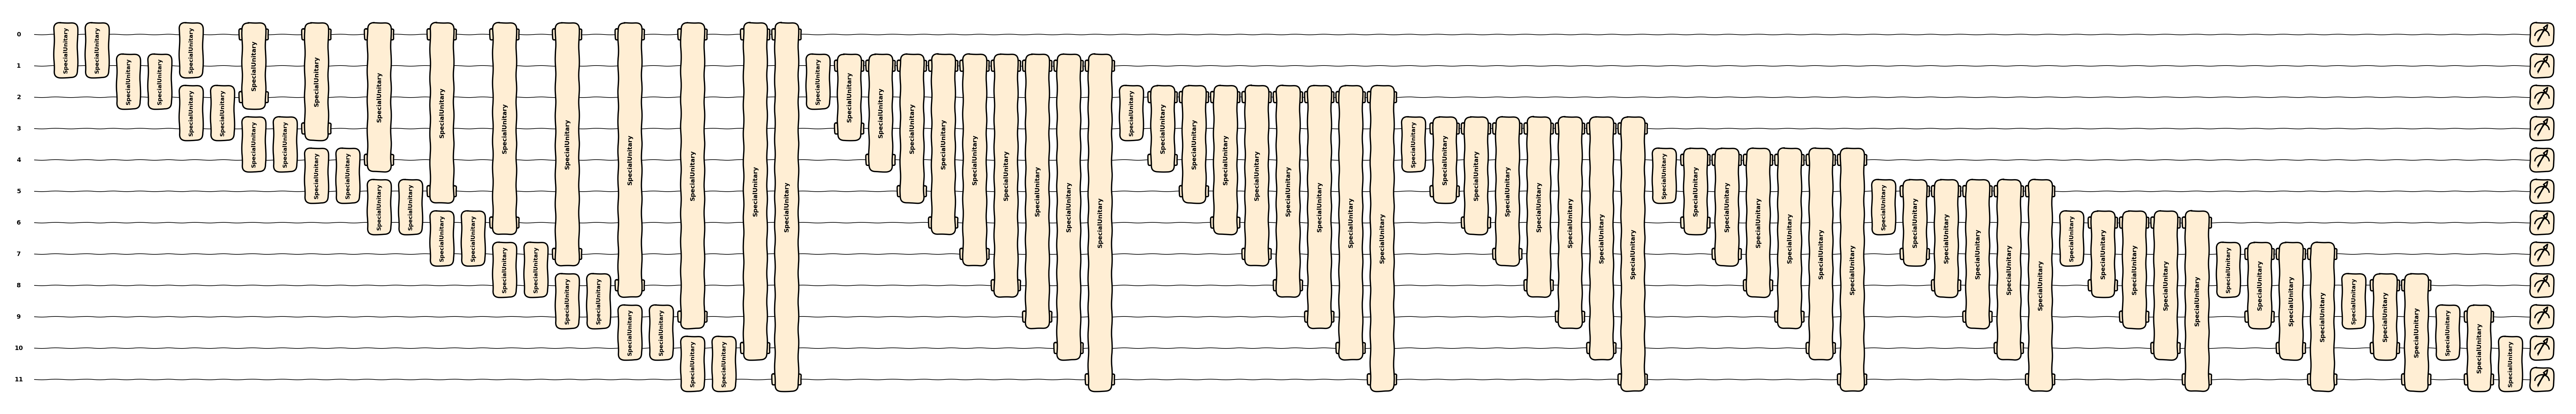

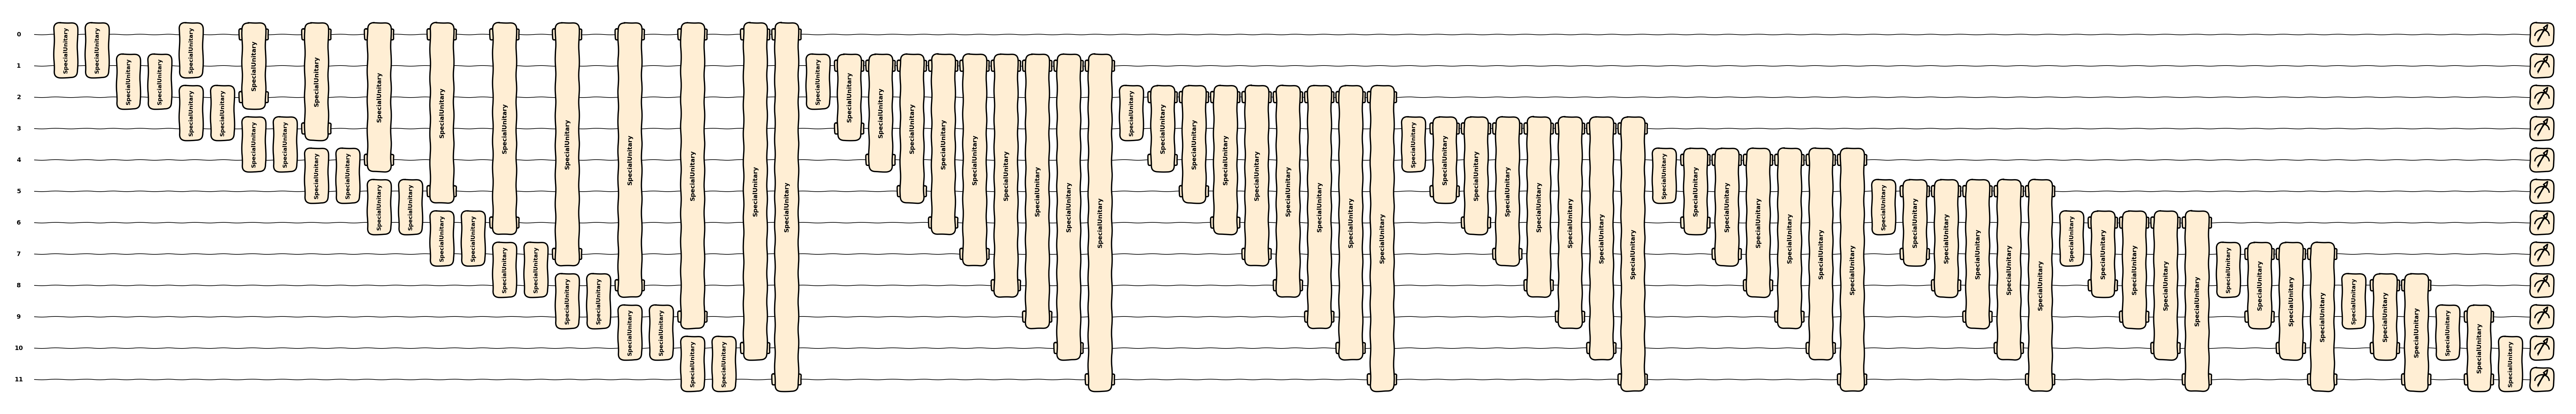

In [4]:
random_initialized_circuit = random_near_identity_extended_circuit.get_random_initialized_circuit(weights_random)
near_unitary_initialized_circuit = random_near_identity_extended_circuit.get_random_initialized_circuit(weights_near_identity)
qml.drawer.draw_mpl(random_initialized_circuit, style="sketch")()
qml.drawer.draw_mpl(near_unitary_initialized_circuit, style="sketch")()

##### Now, we will train the two models using the train_model method. This method takes in the weights as parameters. In the train_model method, one can modify the learning rate and number of iterations. By default, the learning rate is set to 1e-6, and the number of iterations is 15000. For this model, we are setting the learning rate to 0.01, as this gives better resutls, and leaving the number of iterations to 15000.

In [ ]:
params_random, loss_track_random = random_near_identity_extended_circuit.train_model(params_random, learning_rate=0.01)
params_near_identity, loss_track_near_unitary = random_near_identity_extended_circuit.train_model(params_near_identity,learning_rate=0.01)

results['Random Initialization'] = [params_random, loss_track_random]
results['Near Identity Initialization'] = [params_near_identity, loss_track_near_unitary]

##### Bars and stripes images generated from pametric quantum circuit initialized with random SU(4) after training

Frequency : 410
Frequency : 507
Frequency : 484
Frequency : 475
Frequency : 474
Frequency : 473
Frequency : 473
Frequency : 470
Frequency : 469
Frequency : 469
Frequency : 468
Frequency : 466
Frequency : 453
Frequency : 452
Frequency : 449
Frequency : 443
Frequency : 442
Frequency : 432
Frequency : 432
Frequency : 428
Frequency : 418
Frequency : 413


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

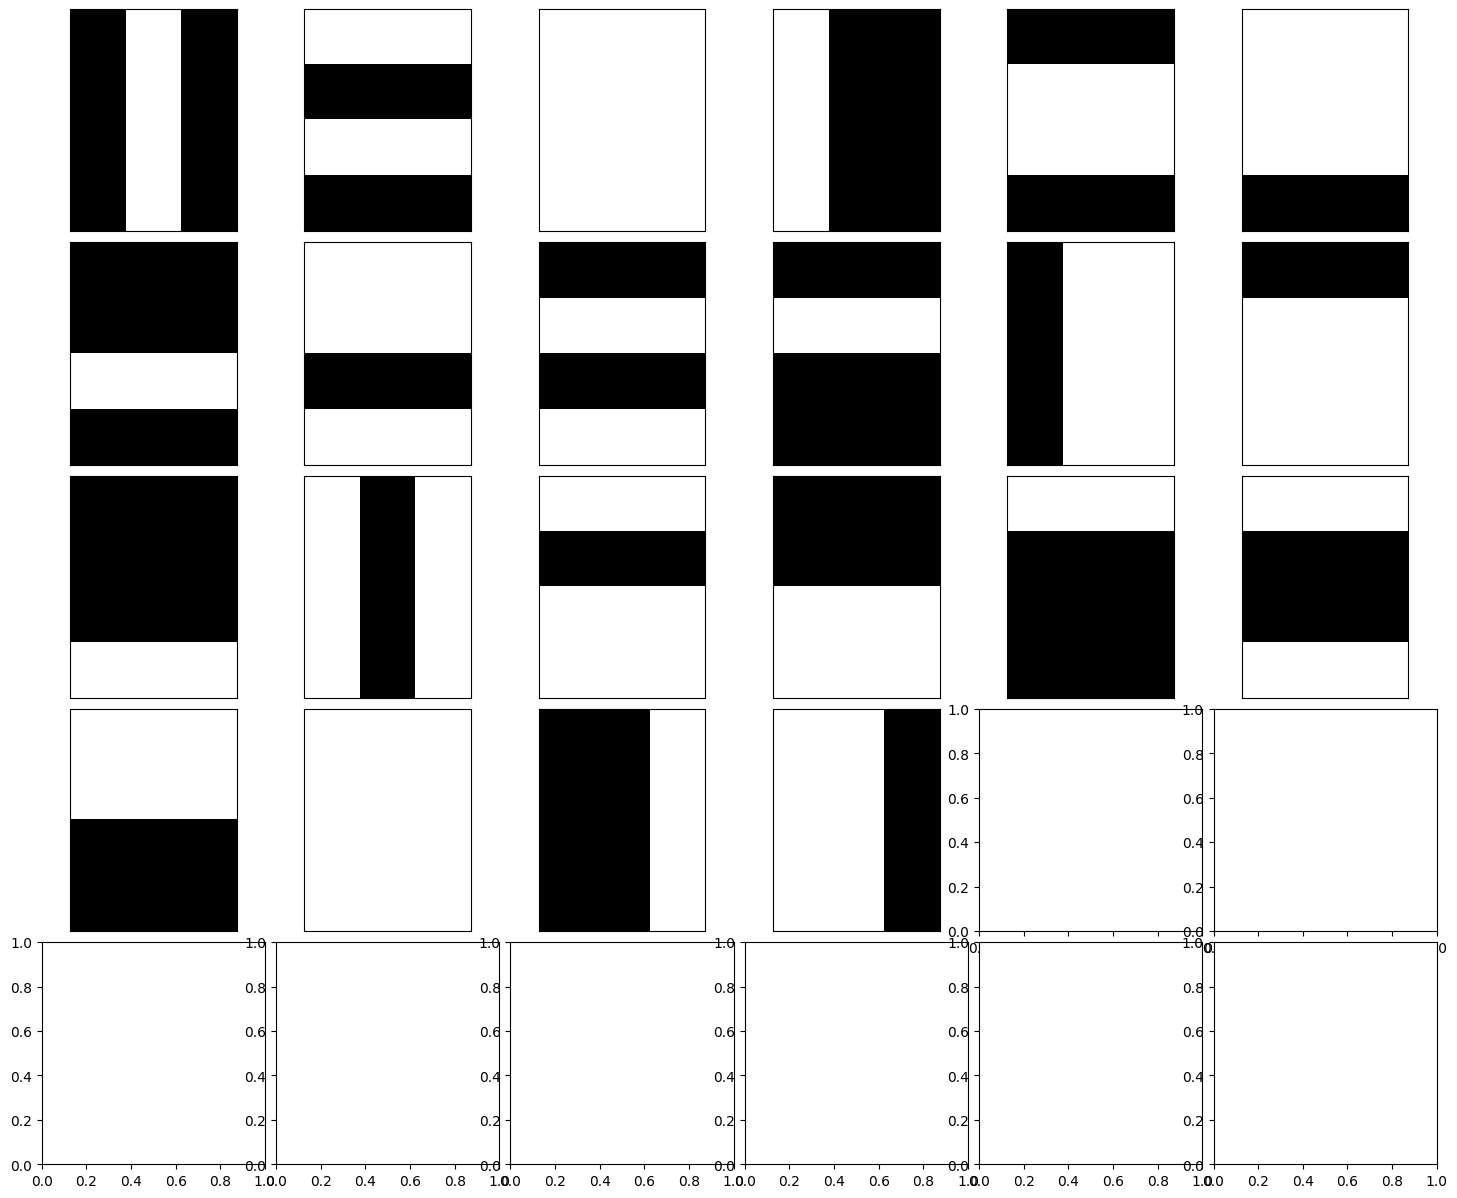

In [7]:
samples = random_near_identity_extended_circuit.get_random_initialized_circuit(results['Random Initialization'][0]['params'], shots = 10000)()
metrics.plot_top_samples_synergy(samples)

##### Bars and stripes images generated from pametric quantum circuit initialized with near identity SU(4) after training

Frequency : 1
Frequency : 484
Frequency : 474
Frequency : 473
Frequency : 469
Frequency : 467
Frequency : 466
Frequency : 463
Frequency : 462
Frequency : 461
Frequency : 457
Frequency : 455
Frequency : 455
Frequency : 455
Frequency : 455
Frequency : 448
Frequency : 446
Frequency : 439
Frequency : 437
Frequency : 432
Frequency : 432
Frequency : 431


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

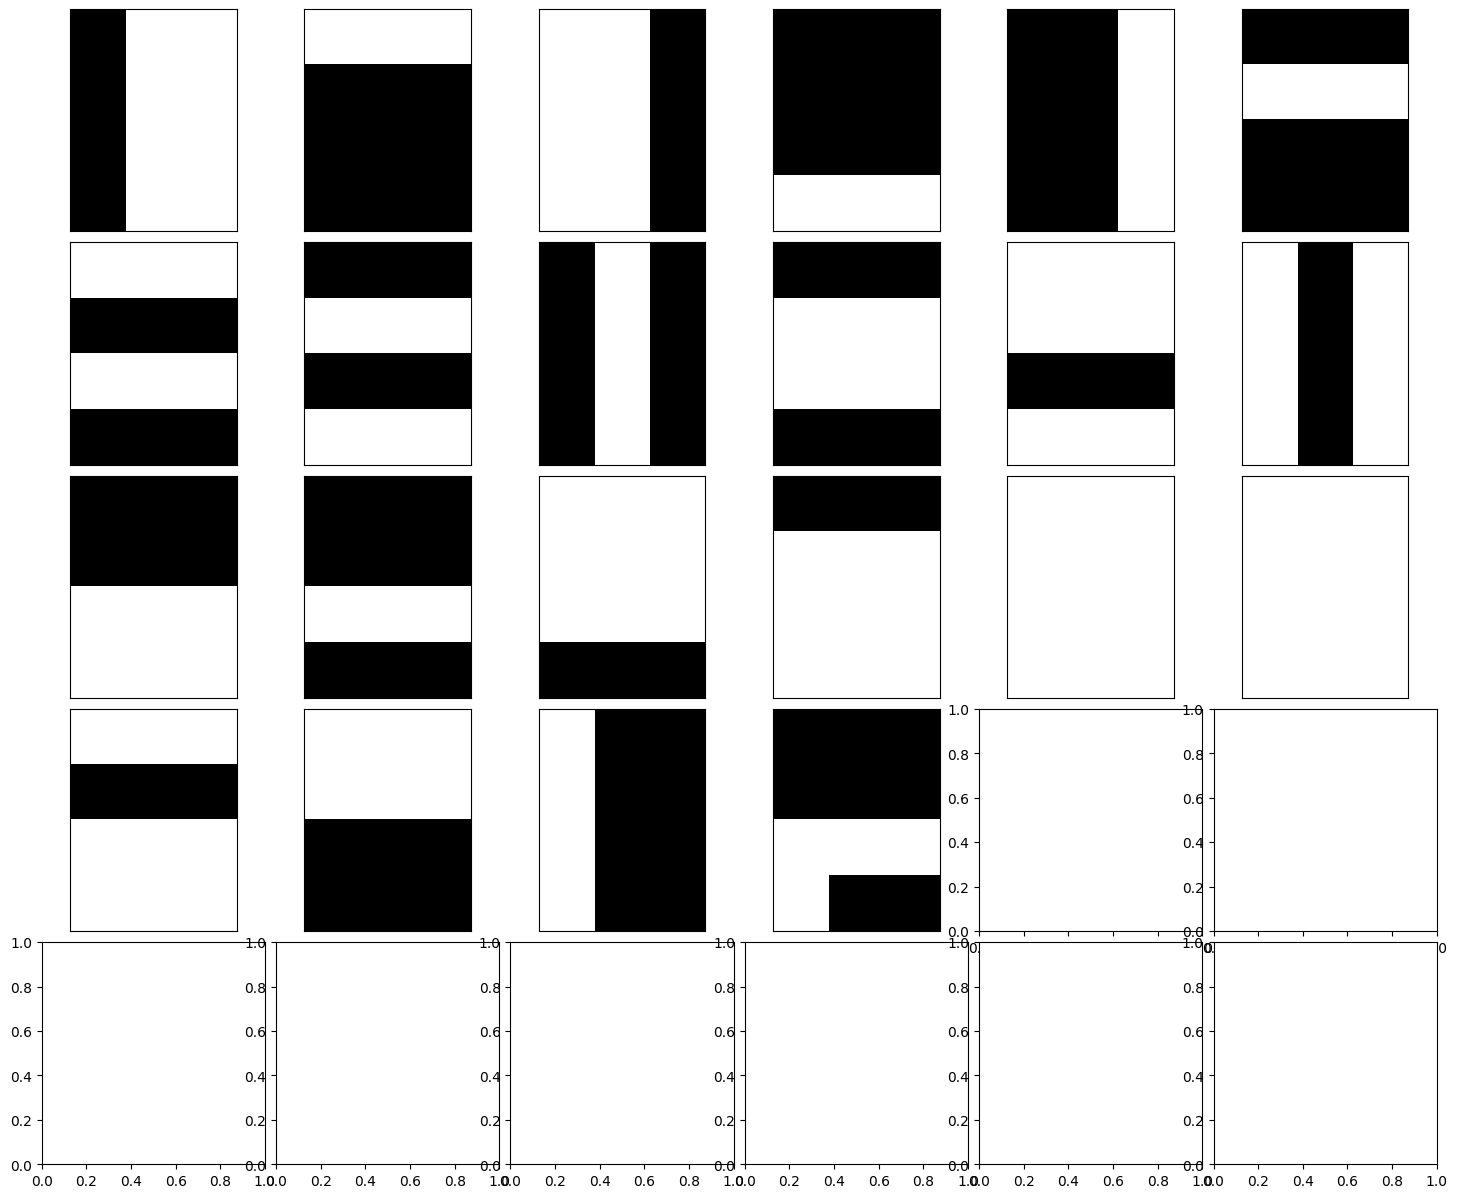

In [8]:
samples = random_near_identity_extended_circuit.get_random_initialized_circuit(results['Near Identity Initialization'][0]['params'], shots = 10000)()
metrics.plot_top_samples_synergy(samples)

### Classical-quantum framework

##### Here, we will use a tensor network model which is first optimized using classical resources to find good task-specific initialization, and is then mapped onto a parameterized quantum circuit. The type of tensor network that we will use is matrix product states (MPS), computationally tractable TN models whose cores are connected along a line graph.



##### With MPS, we are able to generate a quantum circuit. We can take this circuit and extend it with an all-to-all topology of SU(4). Unfortunately, we've found out that `qml.QubitUnitary` by itself is not entirely differentiable and we would have to use the Jacobian w.r.t. each unitary entry to manually do an update. This is going to be very slow and unoptimized. Instead, the plan is to currently work on chi = 2 MPS, which is only mapped to two-qubit unitaries and use exisitng decomposition in qml (KAK decomposition with a fixed template) to turn that into trainable gates and parameters. 

##### Goal : Map the chi = 2 MPS to a trainable PQC, extend the circuit and further train the parameters

##### Steps:
#####    1. Extract the list of unitaries from the MPS
##### 2. Construct the simplest circuit with `qml.QubitUnitary` gates
##### 3. Apply the `qml.transforms.unitary_to_rot` to construct the KAK-decomposed circuit
##### 4. Extend  the circuit with an all-to-all topology of SU(4)
##### 5. Train the newly constructed circuit

##### We start by calling the mps_to_unitaries_circuit method. This will extract unitaries from MPS nad convert them into a circuit. Then, we call the get_expanded_tape method. This method will construct the KAK-decomposition circuit. Below we can see the circuit generated as well. Below we can see the circuit generate after the unitary matrices are extracted from MPS.

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10


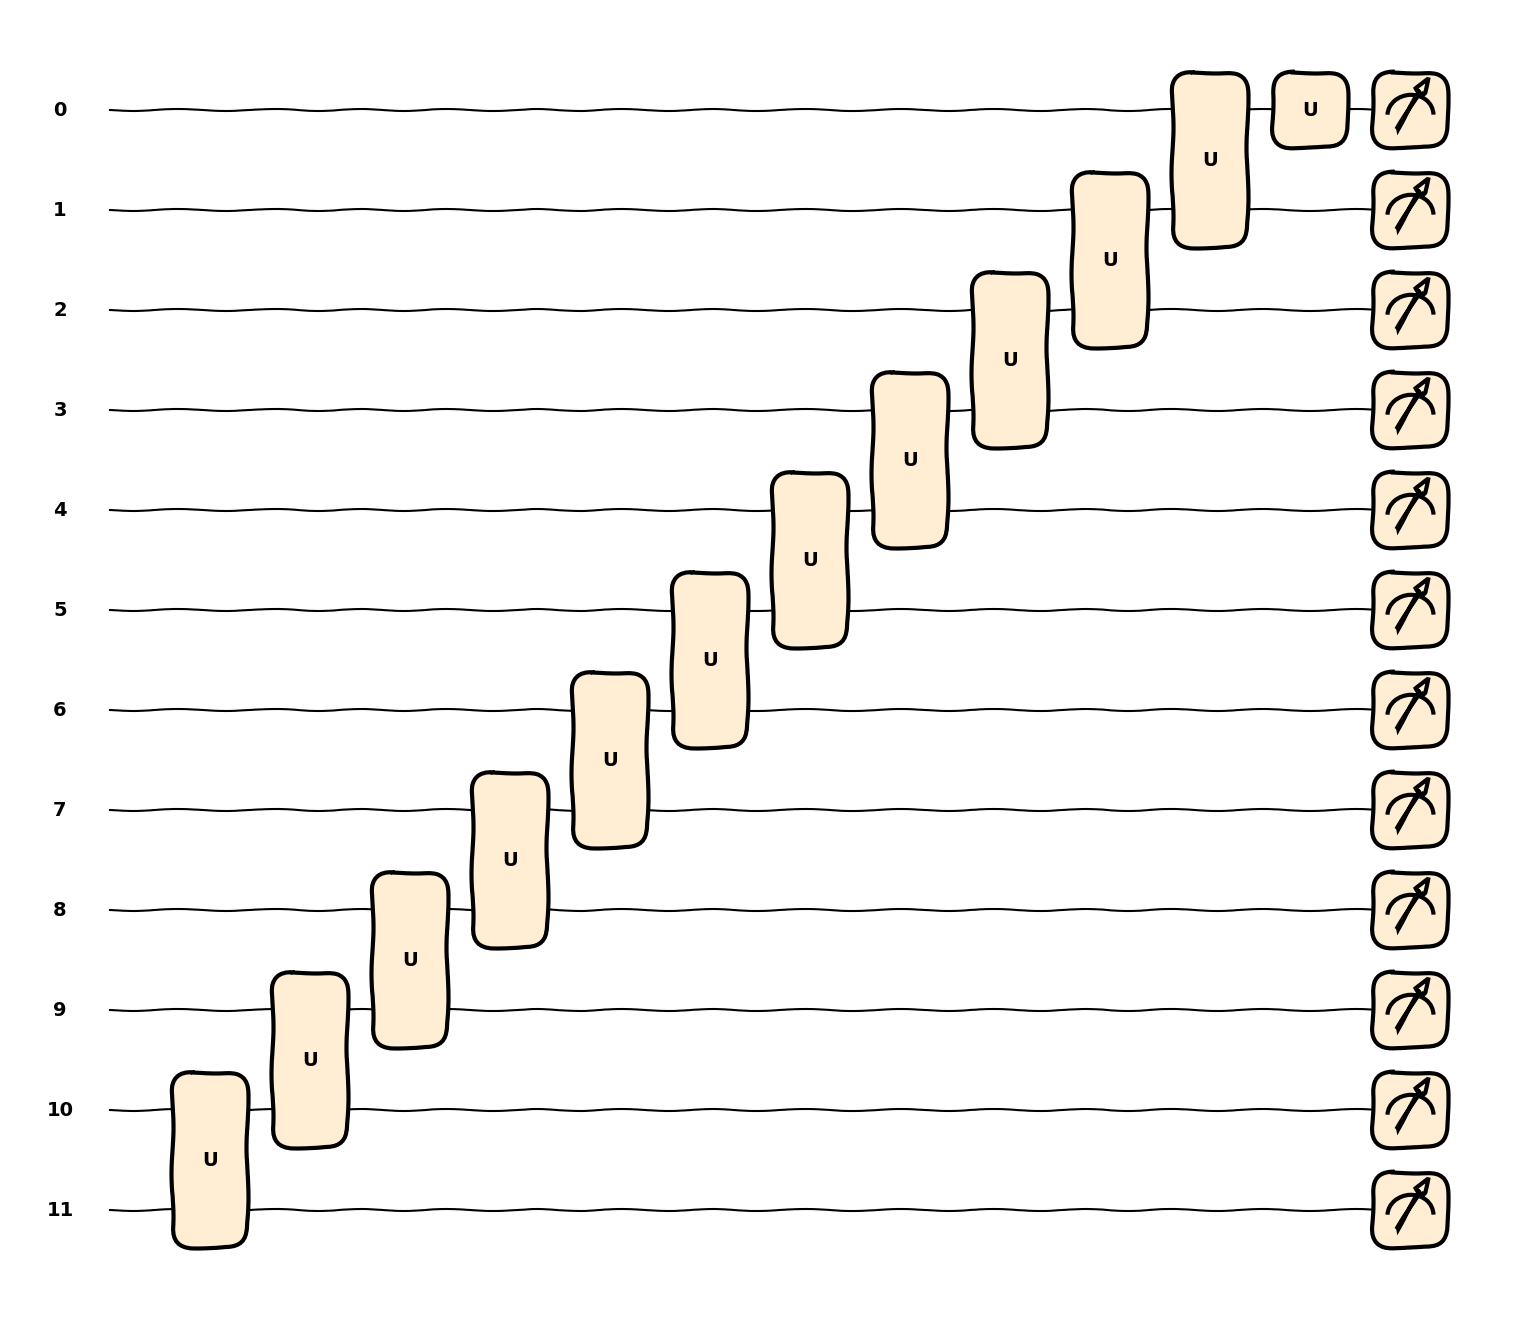

In [9]:
mps_circ = random_near_identity_extended_circuit.mps_to_unitaries_circuit()
random_near_identity_extended_circuit.mps_circ = mps_circ
expanded_tape = random_near_identity_extended_circuit.get_expanded_tape()

##### Next, we will obtain the total number of weights needed for using SU(4) and the wires to apply SU(4) on using all-to-all topology using the method get_details_for_su4_matrices which uses the circuit generated using the get_expanded_tape method

In [10]:
total_num_weights, wires_to_add_su4 = random_near_identity_extended_circuit.get_details_for_su4_matrices(expanded_tape, 12)

##### Let's initialize the parameters needed for the decomposed circuit as well as the SU(4) gates and create the extended circuit. We can compare the circuit generated by MPS and the decomposed circuit that has been extended.

(<Figure size 11600x1300 with 1 Axes>, <Axes: >)

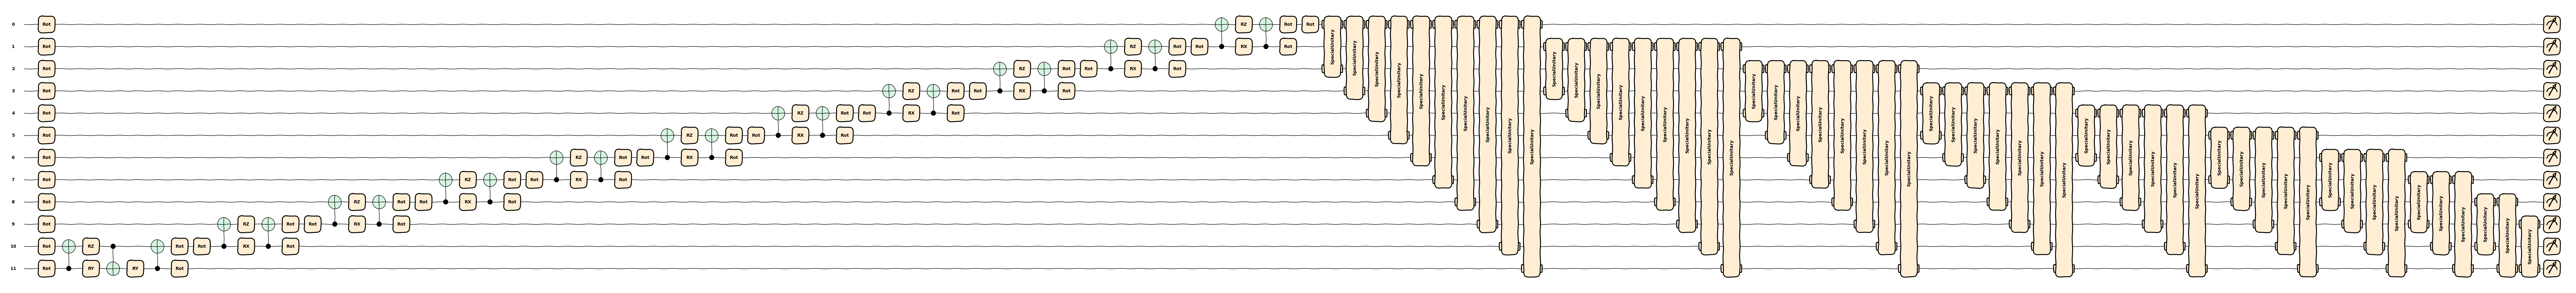

In [11]:
params = jnp.array(qml.math.stack(expanded_tape.data))
params1 = jnp.array(pnp.random.normal(size=(total_num_weights, 15), requires_grad=True))

init_val = {
'params': params,
'params1': params1
}    
extended_circuit = random_near_identity_extended_circuit.get_extended_circuit(init_val['params'], init_val['params1'])

qml.drawer.draw_mpl(extended_circuit, style="sketch")()

##### Now we can train this extended circuit. To trian, we call the train_model method and specify the init_val, string "extended_circuit" so that we can train using the set up for the extended circuit and the learning rate, learning_rate.

In [12]:
init_val, loss_track = random_near_identity_extended_circuit.train_model(init_val, circuit_type="extended_circuit", learning_rate=0.01)
results["Chi = 2 MPS"] = [init_val, loss_track]

  0%|          | 0/15000 [00:00<?, ?it/s]

/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


2023-04-15 01:02:10.426265: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_loss_mps_extended] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-15 01:02:20.797262: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m10.374161s

********************************
[Compiling module jit_loss_mps_extended] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 15000/15000 [55:26<00:00,  4.51it/s]  


##### Bars and stripes images generated from classical-quantum framework

Frequency : 1
Frequency : 504
Frequency : 492
Frequency : 484
Frequency : 474
Frequency : 466
Frequency : 466
Frequency : 462
Frequency : 460
Frequency : 458
Frequency : 454
Frequency : 453
Frequency : 449
Frequency : 434
Frequency : 432
Frequency : 409
Frequency : 401
Frequency : 395
Frequency : 387
Frequency : 380
Frequency : 377
Frequency : 371


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

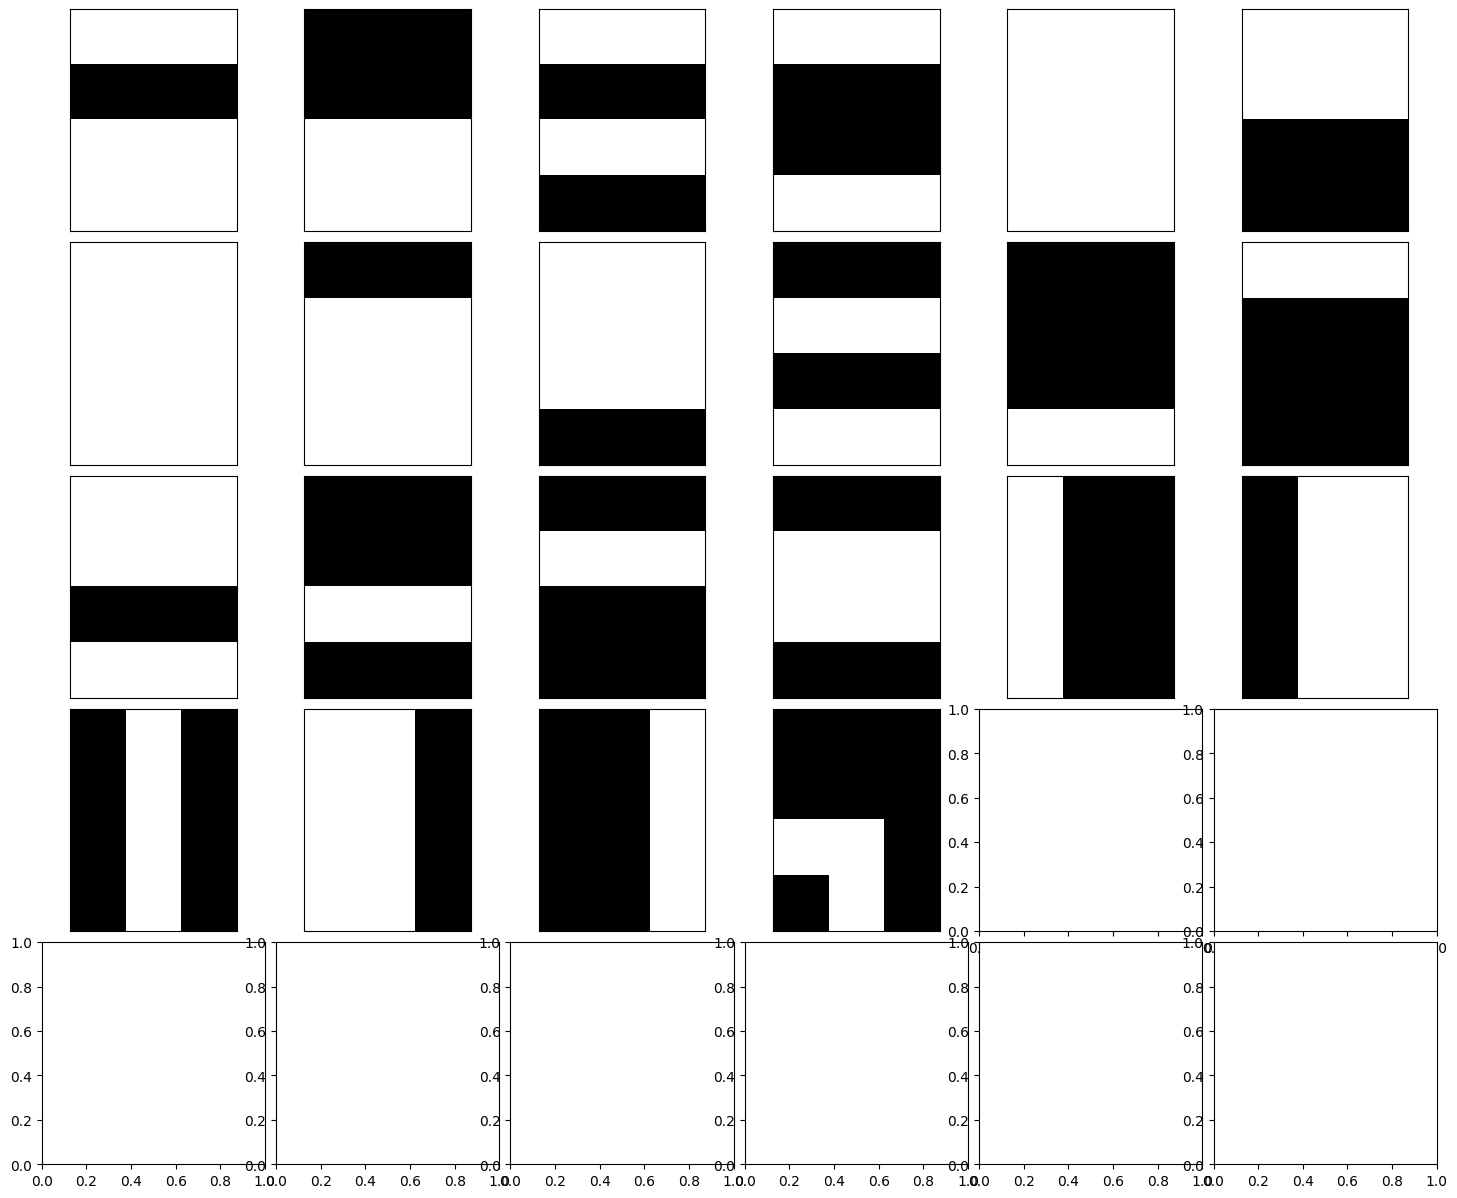

In [14]:
samples = random_near_identity_extended_circuit.get_extended_circuit(results["Chi = 2 MPS"][0]['params'], results["Chi = 2 MPS"][0]['params1'], shots = 10000)()
metrics.plot_top_samples_synergy(samples)

#### Now we can plot the KL divergence for the three models

Text(0, 0.5, 'KL Divergence')

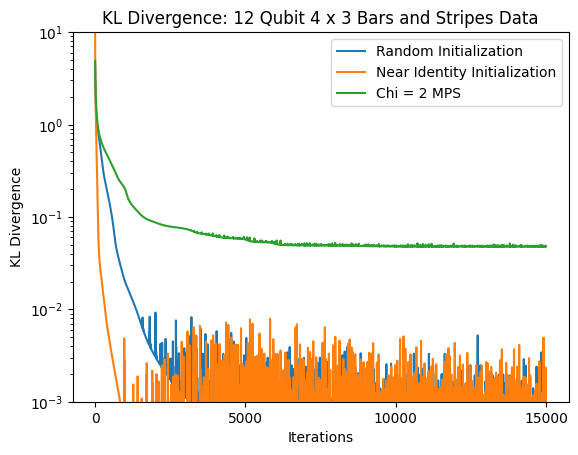

In [15]:
for res in results:
    temp = []
    for loss in results[res][1]:
        temp.append(float(loss)) 
    plt.plot(temp, label = res)
    plt.yscale('log')
plt.ylim(10**-3, 10)
plt.xticks([0, 5000, 10000, 15000])
plt.legend()
plt.title('KL Divergence: 12 Qubit 4 x 3 Bars and Stripes Data')
plt.xlabel('Iterations')
plt.ylabel('KL Divergence')